---
# Problem Description

For my project, I will be implementing the algorithm Clustering via Uncoupled REgression (CURE) from Wang's paper [Efficient Clustering for Stretched Mixtures: Landscape and Optimality](https://arxiv.org/abs/2003.09960). CURE is an adaptation of binary logistic regression that uses clustering to predict labels for the data. 

### Motivation
Many traditional clustering algorithms struggle to cluster elliptically distributed data. KNN, for example, assumes the data is spherically distributed and performs poorly when data is elliptically distributed. CURE seeks to solve this problem by creating a clustering algorithm that excels at clustering elliptically distributed data. My goal is to explicitly show that CURE outperforms KNN on elliptically distributed data.

# Loss Function

### Equations

CURE seeks to find the weights that minimize the loss function
\begin{align}
\boldsymbol{\beta}^* = 
    \underset{ \boldsymbol{\beta} \in \mathbb{R}^{d}}{\arg\min}
    \bigg\{ 
    \frac{1}{n} \sum_{i=1}^{n}
    f( \boldsymbol{\beta}^T \boldsymbol{X_i})
    +
    \frac{1}{2} (\boldsymbol{\beta}^T \hat{\boldsymbol{\mu_0}})^2
    \bigg\}
\end{align}

where $\boldsymbol{\beta} \in \mathbb{R}^d$ are the weights, $\boldsymbol{\beta}^{*} \in \mathbb{R}^d$ are the optimal weights that minimize the above equation, $\boldsymbol{X_i} \in \mathbb{R}^d$ is a sample data point with $d$ features, $\boldsymbol{X} \in \mathbb{R}^{n \times d}$ is a matrix of $n$ datapoints each with $d$ features, and $\hat{\boldsymbol{\mu_0}} = \frac{1}{n} \sum_{i=1}^{n} \boldsymbol{X_i}$ is the value of the average data point. To get $\boldsymbol{X}$ we preappend a column of ones $\boldsymbol{1} \in \mathbb{R}^n$ to the data (which is really $\mathbb{R}^{n \times (d - 1)}$) to give us an intercept term. 

The discriminative function $f : \mathbb{R} \rightarrow \mathbb{R}$ is defined as


$$
f(x)
=
\begin{cases}
        h(x)
        & 
        |x| \leq a 
        \\
        f(a) + h'(a) (|x| - a) 
        + \frac{h''(a)}{2} (|x| - a)^2 
        - \frac{h''(a)}{6(b-a)} (|x| - a)^3
        & 
        a < |x| \leq b 
        \\
        f(b) 
        + \Big[ h(a) + \frac{b-a}{2} h''(a) \Big] (|x| - b)
        & 
        |x| > b
        \\
    \end{cases}
$$
where $b > a > 1$ and $h(x) = \frac{(x^2-1)^2}{4}$

### Explanation

We embed the data $\boldsymbol{X}$ into 1D space via the dot product $x = \boldsymbol{\beta}^T \boldsymbol{X_i}$. Then we plug $x$ into the discriminative function $f$ to separate, ie. discriminate, the embedded data into two clusters. How does this work? $f$ and $h$ both have minimums at both x=±1 so minimizing these equations will map many of our datapoints to x=1 and many of them to x=-1, resulting in two different clusters. Because $h$ becomes huge for large $x$ values ($h$ is quartic), we construct $f$ which is just like $h$ except that when $x$ is too big we clip its growth with linear functions. More explitically, $f$ has three parts. When $x$ is small, $|x| \leq a$, we will minimize $h$ which has two valleys around ±1. When $x$ is too big, $|x| > b$, we will minimize a linear function so our values don't blow up. When $x$ is somewhere in between, $a < |x| \leq b$, we use a cubic spline to connect the valleys to the linear function.

![Discriminate functions](reports/figures/discriminant.png)

So $ \frac{1}{n} \sum_{i=1}^{n} f( \boldsymbol{\beta}^T \boldsymbol{X_i})$ embeds the data $\boldsymbol{X}$ in 1D space and computes on average how well the data is separated into two clusters located at x=±1. The lower this value, the better. However, we can minimize this function by clustering all of the datapoints into a single cluster. To avoid this trivial solution, we use the penalty term $\frac{1}{2} (\boldsymbol{\beta}^T \hat{\boldsymbol{\mu_0}})^2$. This term encourages the data $\boldsymbol{X}$ to be evenly split between the two clusters at x=±1 as this term has the lowest value when $\hat{\boldsymbol{\mu_0}} = 0$ which only occurs when the data is evenly split between both clusters. 

Putting it all together, the loss function embeds the data $\boldsymbol{X} $ in 1D space and computes on average how well the data is separated into two evenly sized clusters located at x=±1. We minimize this score and record the weights, $\boldsymbol{\beta}^*$, that result in this minimization.

### Clustering
Once we have computed $\boldsymbol{\beta}^*$, the clustering comes into play:
\begin{align}
    y^{\text{pred}}_i
    &= 
    \text{sgn}( \boldsymbol{\beta}^* \boldsymbol{X_i} ) 
\end{align}
where $y^{\text{pred}}_i$ is the predicted label of the $i\text{th}$ sample. This function puts all positive datapoints into one cluster and all negative datapoints into a different cluster. And these are our clusters! That's it.

---
# Coding Overview

I designed CURE so it resembles many of the classifiers in `scikit-learn`. I did this by creating a `CURE` class with the following methods:

1. *\_\_init__* When you initialize the class, you specify the the random seed and the parameters `a, b`.
2. *fit()* This method takes in the data and labels and uses them to train the model. Behind the scenes, it uses `scikit-learn`'s minimization function to find the weights that best minimize the loss function.
3. *predict()* This method takes in the data and uses the weights to predict the labels. It returns the predicted labels using the equation $ y^{\text{pred}}_i = \text{sgn}( \boldsymbol{\beta}^* \boldsymbol{X_i} ) $.
4. *fit_predict()* This method calls both `fit` and `predict` on the training data. Thus, it takes the data and labels and uses them to train the model and then predicts the labels. It returns the predicted labels.

---
# Experiments

Adjusted Rand Index = 0.988
Misclassification Rate = 0.300%


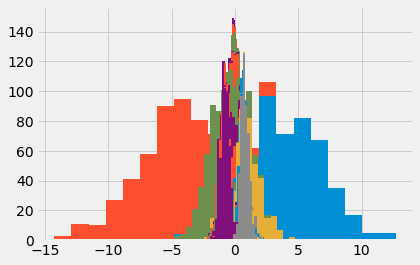

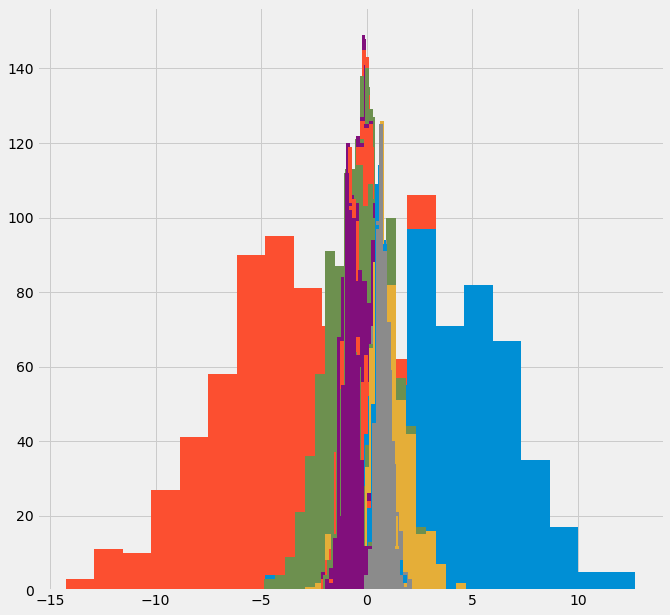

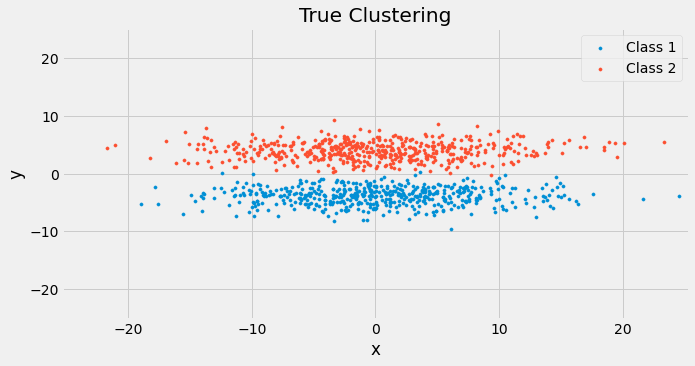

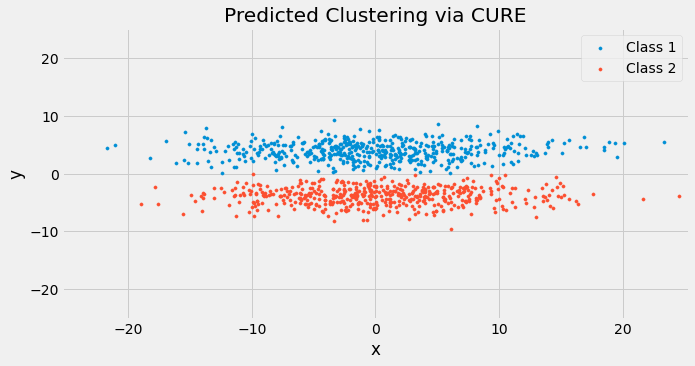

In [9]:
from main import experiment1

results = experiment1()

In [11]:
from matplotlib import pyplot as plt
from IPython.display import HTML

from IPython.display import HTML
HTML(results['anim_matplt'].to_html5_video())


In [14]:
from matplotlib import rc
rc('animation', html='jshtml')

results['anim_matplt']

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/home/ezt2102/miniconda3/envs/cure/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-yp9kxp8j/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Finished downloading the Fashion MNIST data.
Normalizing the Fashion MNIST data...
Finished normalizing the Fashion MNIST data.
Extracting the desired classes...
0/60000
50/60000
100/60000
150/60000
200/60000
250/60000
300/60000
350/60000
400/60000
450/60000
500/60000
550/60000
600/60000
650/60000
700/60000
750/60000
800/60000
850/60000
900/60000
950/60000
1000/60000
1050/60000
1100/60000
1150/60000
1200/60000
1250/60000
1300/60000
1350/60000
1400/60000
1450/60000
1500/60000
1550/60000
1600/60000
1650/60000
1700/60000
1750/60000
1800/60000
1850/60000
1900/60000
1950/60000
2000/60000
2050/60000
2100/60000
2150/60000
2200/60000
2250/60000
2300/60000
2350/60000
2400/60000
2450/60000
2500/60000
2550/60000
2600/60000
2650/60000
2700/60000
2750/60000
2800/60000
2850/60000
2900/60000
2950/60000
3000/60000
3050/60000
3100/60000
3150/60000
3200/60000
3250/60000
3300/60000
3350/60000
3400/60000
3450/60000
3500/60000
3550/60000
3600/60000
3650/60000
3700/60000
3750/60000
3800/60000
3850/60000
390

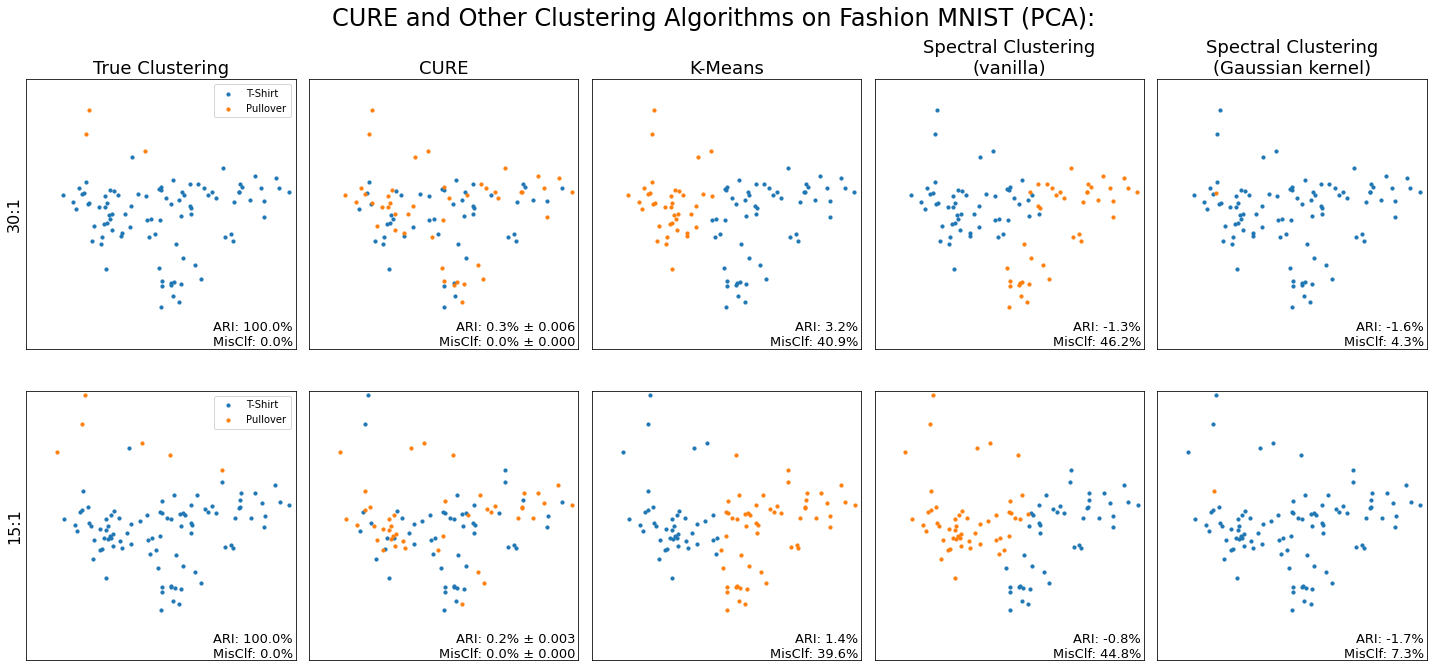

In [5]:
from main import experiment4

fig, ari_df, misclf_df = experiment4()

In [6]:
print('-'*15, 'Adjusted Rand Index Scores', '-'*15)
ari_df

--------------- Adjusted Rand Index Scores ---------------


Class Ratio,30:1,15:1
CURE,0.3% ± 0.006,0.2% ± 0.003
K-Means,3.2%,1.4%
Spectral Clustering\n(vanilla),-1.3%,-0.8%
Spectral Clustering\n(Gaussian kernel),-1.6%,-1.7%


In [7]:
print('-' * 15, 'Misclassification Rates', '-' * 15)
misclf_df

--------------- Misclassification Rates ---------------


Class Ratio,30:1,15:1
CURE,0.0% ± 0.000,0.0% ± 0.000
K-Means,40.9%,39.6%
Spectral Clustering\n(vanilla),46.2%,44.8%
Spectral Clustering\n(Gaussian kernel),4.3%,7.3%
